# CytoTRACE vs. CytoTRACEKernel benchmark

## Library imports

In [1]:
import os
import sys
from typing import Dict

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv
from anndata import AnnData

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

In [4]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "cytotrace_kernel" / "benchmark", exist_ok=True)

## Function definition

In [5]:
def get_score_agreement(
    adata: AnnData,
    ground_truth_maturity: Dict,
    cyto_trace_key: str = "ct_pseudotime",
    groupby: str = "clusters",
):
    """Quantify agreement between cyto_trace maturity score and ground-truth.

    Parameters
    ----------
    ground_truth_maturity
        Dict of `cluster: maturity`
    cyto_trace_key
        Key from `adata.obs` where cyto_trace score assesing maturity can be found.
        Higher values shoudl correspond to more mature cell types (i.e. like a pseudotime)
    groupby
        Denotes where to find the categorical group annotation that should be used to average the
        cyto-trace score
    use_kendalltau
        If true, use `scipy.stats.kendalltau`, else use `scipy.states.spearmanr`

    Returns
    -------
    Results of the association test
    """
    # Get the average cyto-trace score
    clusters = adata.obs[groupby].cat.categories
    cyto_trace_maturity = {
        cluster: np.mean(adata[adata.obs[groupby] == cluster].obs[cyto_trace_key]) for cluster in clusters
    }

    # Put both as columns in a DataFrame
    maturity_df = pd.DataFrame.from_dict(ground_truth_maturity, orient="index", columns=["gt"])
    maturity_df["cyto_trace"] = maturity_df.index.map(cyto_trace_maturity)

    # Compute association
    return spearmanr(maturity_df["gt"], maturity_df["cyto_trace"])

In [6]:
def get_consistency(adatas: Dict[str, AnnData]):
    """Quantify consistency between original vs. re-implementation.

    Parameters
    ----------
    validation_data_work
        data_work sets where the comparison is to be performed

    Returns
    -------
    results: contains the comparison as a DataFrame
    scores: the computed CytoTRACE scores
    """
    # Create DataFrame for the results (the actual comparison scores)
    results = pd.DataFrame(
        index=adatas.keys(),
        columns=["CytoTRACEKernel vs. GT", "CytoTRACE vs. GT", "Pearson corr. CytoTRACEKernel vs. CytoTRACE"],
    )

    # Create a dict for the computed CytoTRACE scores
    scores = {}

    # loop over data_worksets
    for dataset, adata in adatas.items():
        print(f"\nProcessing {dataset}\n")

        # Make a copy of the object
        data_work = adata.copy()

        # Filter genes
        sc.pp.filter_genes(data_work, min_cells=10)
        data_work.raw = data_work.copy()

        # Normalize and log transform
        scv.pp.normalize_per_cell(data_work)
        sc.pp.log1p(data_work)

        # Annotate (but do not filter to) highly variable genes
        sc.pp.highly_variable_genes(data_work)

        # Compute PCA and neighbors
        sc.tl.pca(data_work)
        sc.pp.neighbors(data_work, n_pcs=30, n_neighbors=30)

        # Prepare data imputation (scvelo's `moments` function operates on unspliced/spliced layers)
        data_work.layers["spliced"] = data_work.X
        data_work.layers["unspliced"] = data_work.X

        scv.pp.moments(data_work, n_pcs=None, n_neighbors=None)

        # Check that we have in fact computed imputed expression values for all (not just hv) genes
        assert data_work.layers["Ms"].shape[1] == data_work.X.shape[1], "Imputed shape does not match raw shape"

        # Instantiate a CytoTRACE kernel from cellrank and compute the CytoTRACE score
        _ = cr.kernels.CytoTRACEKernel(data_work).compute_cytotrace()

        # Create a dict that stores the ground truth per cluster
        diff_state_gt = {
            ground_truth_cat: ground_truth_cat_id
            for ground_truth_cat_id, ground_truth_cat in enumerate(data_work.obs["Ground_truth"].cat.categories)
        }

        # Quantify agreement between reimplementation and ground truth
        spearman_corr = {}
        spearman_corr["CytoTRACEKernel vs. GT"] = get_score_agreement(
            data_work, ground_truth_maturity=diff_state_gt, groupby="Ground_truth", cyto_trace_key="ct_pseudotime"
        )

        # Quantify agreement between original implementation and ground truth
        spearman_corr["CytoTRACE vs. GT"] = get_score_agreement(
            data_work,
            ground_truth_maturity=diff_state_gt,
            groupby="Ground_truth",
            cyto_trace_key="original_ct_pseudotime",
        )

        # Quantify correlation among the two measures
        pearson_corr = np.corrcoef(x=data_work.obs["ct_pseudotime"], y=data_work.obs["original_ct_pseudotime"])[0, 1]

        # write to the results data_Frame
        results.loc[dataset, "CytoTRACEKernel vs. GT"] = spearman_corr["CytoTRACEKernel vs. GT"].correlation
        results.loc[dataset, "CytoTRACE vs. GT"] = spearman_corr["CytoTRACE vs. GT"].correlation
        results.loc[dataset, "Pearson corr. CytoTRACEKernel vs. CytoTRACE"] = pearson_corr
        scores[dataset] = data_work.obs["ct_pseudotime"]

    return results, scores

## C. elegans - Hypodermis and seam

## Data loading

In [7]:
adatas = {}

adatas["Bone marrow 10x (Schaum et al., Nature 2018)"] = sc.read(
    DATA_DIR / "tabula_muris" / "raw" / "Bone_marrow_10x_matrix.txt"
).T
adatas["Bone marrow SmartSeq2 (Schaum et al., Nature 2018)"] = sc.read(
    DATA_DIR / "tabula_muris" / "raw" / "Bone_marrow_smartseq2_matrix.txt"
).T

adatas["C. elegans ciliated neurons (Packer et al., Science 2019)"] = sc.read(
    DATA_DIR / "c_elegans" / "raw" / "Ciliated_neurons_celegans_matrix.txt"
).T
adatas["C. elegans hypodermis and seam (Packer et al., Science 2019)"] = sc.read(
    DATA_DIR / "c_elegans" / "raw" / "Hypodermis_and_seam_celegans_matrix.txt"
).T
adatas["C. elegans muscle and mesoderm (Packer et al., Science 2019)"] = sc.read(
    DATA_DIR / "c_elegans" / "raw" / "Muscle_and_mesoderm_celegans_matrix.txt"
).T

adatas["Zebrafish embryogenesis (Farrell et al., Science 2018)"] = sc.read(
    DATA_DIR / "zebrafish" / "raw" / "GSE106474_UMICounts.txt"
).T

adatas

{'Bone marrow 10x (Schaum et al., Nature 2018)': AnnData object with n_obs × n_vars = 3427 × 13526,
 'Bone marrow SmartSeq2 (Schaum et al., Nature 2018)': AnnData object with n_obs × n_vars = 4442 × 17479,
 'C. elegans ciliated neurons (Packer et al., Science 2019)': AnnData object with n_obs × n_vars = 10775 × 20222,
 'C. elegans hypodermis and seam (Packer et al., Science 2019)': AnnData object with n_obs × n_vars = 12254 × 20222,
 'C. elegans muscle and mesoderm (Packer et al., Science 2019)': AnnData object with n_obs × n_vars = 22370 × 20222,
 'Zebrafish embryogenesis (Farrell et al., Science 2018)': AnnData object with n_obs × n_vars = 39505 × 23974}

In [8]:
metadata = {}

metadata["Bone marrow 10x (Schaum et al., Nature 2018)"] = pd.read_csv(
    DATA_DIR / "tabula_muris" / "raw" / "Bone_marrow_10x_metadata.txt", sep="\t", skiprows=None, index_col=None
)

metadata["Bone marrow SmartSeq2 (Schaum et al., Nature 2018)"] = pd.read_csv(
    DATA_DIR / "tabula_muris" / "raw" / "Bone_marrow_smartseq2_metadata.txt", sep="\t", skiprows=None, index_col=None
)

metadata["C. elegans ciliated neurons (Packer et al., Science 2019)"] = pd.read_csv(
    DATA_DIR / "c_elegans" / "raw" / "Ciliated_neurons_celegans_metadata.txt", sep="\t", skiprows=None, index_col=None
).join(
    pd.read_csv(
        DATA_DIR / "c_elegans" / "cedata-Ciliated neuronsdownmeta-2021-03-15.csv",
        skiprows=None,
        index_col=0,
    ),
    how="inner",
)

metadata["C. elegans hypodermis and seam (Packer et al., Science 2019)"] = pd.read_csv(
    DATA_DIR / "c_elegans" / "raw" / "Hypodermis_and_seam_celegans_metadata.txt",
    sep="\t",
    skiprows=None,
    index_col=None,
)

metadata["C. elegans muscle and mesoderm (Packer et al., Science 2019)"] = pd.read_csv(
    DATA_DIR / "c_elegans" / "raw" / "Muscle_and_mesoderm_celegans_metadata.txt",
    sep="\t",
    skiprows=None,
    index_col=None,
)

metadata["Zebrafish embryogenesis (Farrell et al., Science 2018)"] = (
    pd.read_csv(
        DATA_DIR / "zebrafish" / "raw" / "metadata" / "URD_Dropseq_Meta.txt", sep="\t", skiprows=[1], index_col=0
    )
    .join(
        pd.read_csv(
            DATA_DIR / "zebrafish" / "raw" / "metadata" / "URD_Dropseq_Cluster_tSNEAll.txt",
            sep="\t",
            skiprows=[1],
            index_col=0,
        ).rename(columns={old_column_name: f"{old_column_name}_tsne" for old_column_name in ["X", "Y", "Z"]}),
        how="inner",
    )
    .join(
        pd.read_csv(
            DATA_DIR / "zebrafish" / "raw" / "metadata" / "URD_Dropseq_Cluster_URDDevelopmentalTree.txt",
            sep="\t",
            skiprows=[1],
            index_col=0,
        ).rename(columns={old_column_name: f"{old_column_name}_force_directed" for old_column_name in ["X", "Y", "Z"]}),
        how="left",
    )
    .join(
        pd.read_csv(DATA_DIR / "zebrafish" / "raw" / "metadata" / "Zebrafish_metadata.txt", sep="\t").rename(
            columns={"Phenotype": "ct_phenotype", "Component_1": "ct_component_1", "Component_2": "ct_component_2"}
        ),
        how="inner",
    )
    .join(
        pd.read_csv(DATA_DIR / "zebrafish" / "raw" / "metadata" / "2021-03-10_cluster_labels.csv", index_col=0).rename(
            columns={"ZF6S-Tips-Named": "gt_terminal_states"}
        ),
        how="left",
    )
)

### Data processing

In [9]:
for dataset in adatas.keys():
    adatas[dataset].X = csr_matrix(adatas[dataset].X).copy()

    updated_obs = adatas[dataset].obs.join(metadata[dataset], how="inner")
    adatas[dataset] = adatas[dataset][updated_obs.index].copy()

    pd.testing.assert_index_equal(left=adatas[dataset].obs_names, right=updated_obs.index)

    adatas[dataset].obs = updated_obs

    adatas[dataset].obs["Ground_truth"] = adatas[dataset].obs["Ground_truth"].astype("category")
    adatas[dataset].obs["original_ct_pseudotime"] = (
        1 - adatas[dataset].obs["CytoTRACE"].values / adatas[dataset].obs["CytoTRACE"].values.max()
    )

In [10]:
dataset = "C. elegans muscle and mesoderm (Packer et al., Science 2019)"

adatas[dataset].obs["Ground truth continuous"] = adatas[dataset].obs["Ground_truth"].astype(float).values.copy()
adatas[dataset].obsm["X_ct"] = np.concatenate(
    (adatas[dataset].obs["Component_1"].values[:, None], adatas[dataset].obs["Component_2"].values[:, None]), axis=1
)

## CytoTRACE score comparison

In [11]:
df_results, scores = get_consistency(adatas)


Processing Bone marrow 10x (Schaum et al., Nature 2018)

filtered out 923 genes that are detected in less than 10 cells
Normalized count data: X.
extracting highly variable genes
    finished (0:00:00)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:06)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Computing CytoTRACE score with `12603` genes
DEBUG: Correlating all genes with number of genes expressed per cell
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)

Processing Bone marrow SmartSeq2 (Schaum et al., Nature 2018)

filtered out 1589 genes that are detected in less than 10 cells
Normalized count da

In [12]:
df_results["label"] = [
    f"{name}: r={corr:.2f}"
    for name, corr in zip(df_results.index, df_results["Pearson corr. CytoTRACEKernel vs. CytoTRACE"])
]
df_results["label"] = pd.Series(df_results["label"], dtype="category")

<Figure size 480x480 with 0 Axes>

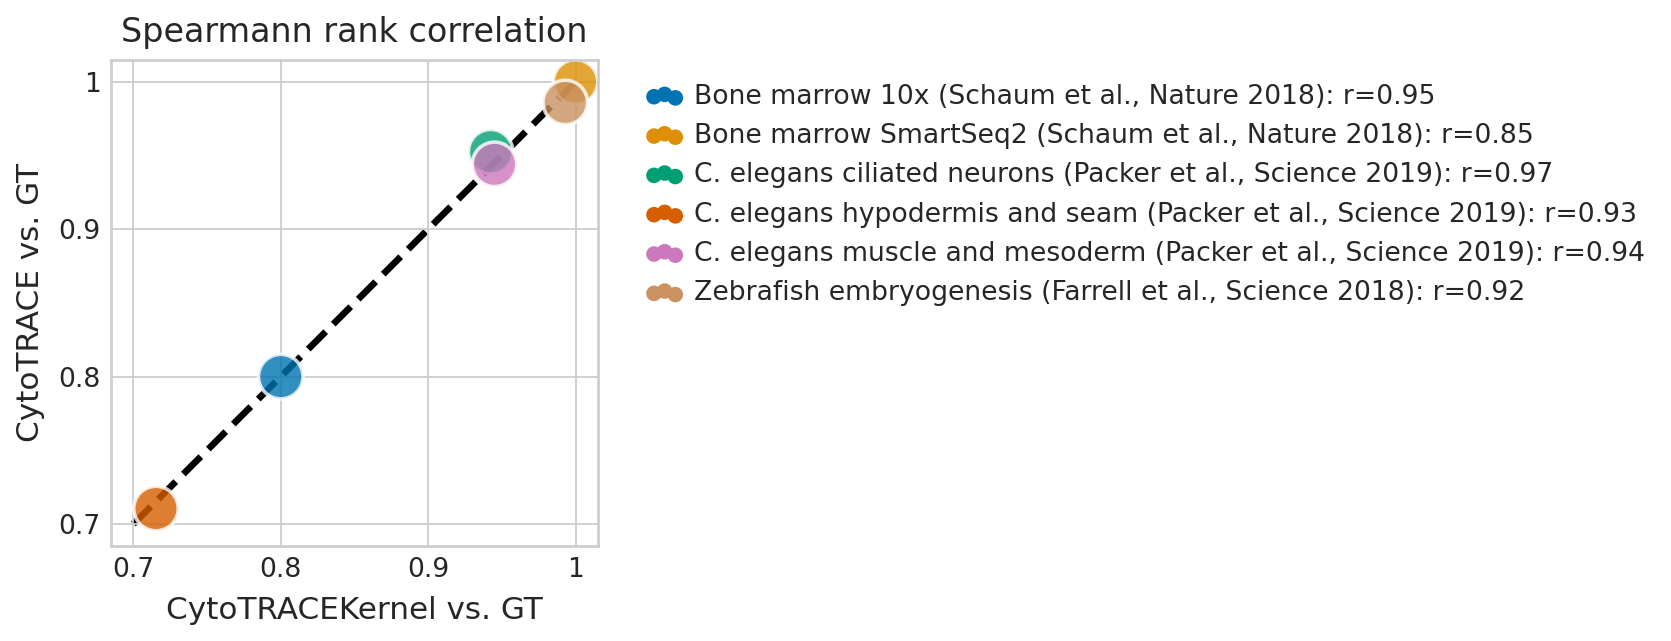

In [13]:
plt.figure(figsize=(6, 6))
ax_min, ax_max = 0.7, 1.0
ticks = [0.7, 0.8, 0.9, 1]

# Set the colorblind-friendly color palette
color_palette = sns.color_palette("colorblind", n_colors=df_results.shape[0])

with mplscience.style_context():
    sns.set_style(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(
        data=df_results,
        x="CytoTRACEKernel vs. GT",
        y="CytoTRACE vs. GT",
        hue="label",
        s=400,
        alpha=0.8,
        palette="colorblind",
        ax=ax,
    )
    ax.plot([ax_min, ax_max], [ax_min, ax_max], "k--", zorder=0, linewidth=3)

    # Figure asthetics
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.set_title("Spearmann rank correlation")
    ax.set_xticks(ticks=ticks, labels=ticks)
    ax.set_yticks(ticks=ticks, labels=ticks)
    ax.axis("square")

    plt.show()

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "cytotrace_kernel" / "benchmark" / "cytotrace_vs_cytotracekernel_comparison.pdf",
            format="pdf",
            transparent=True,
            bbox_inches="tight",
        )

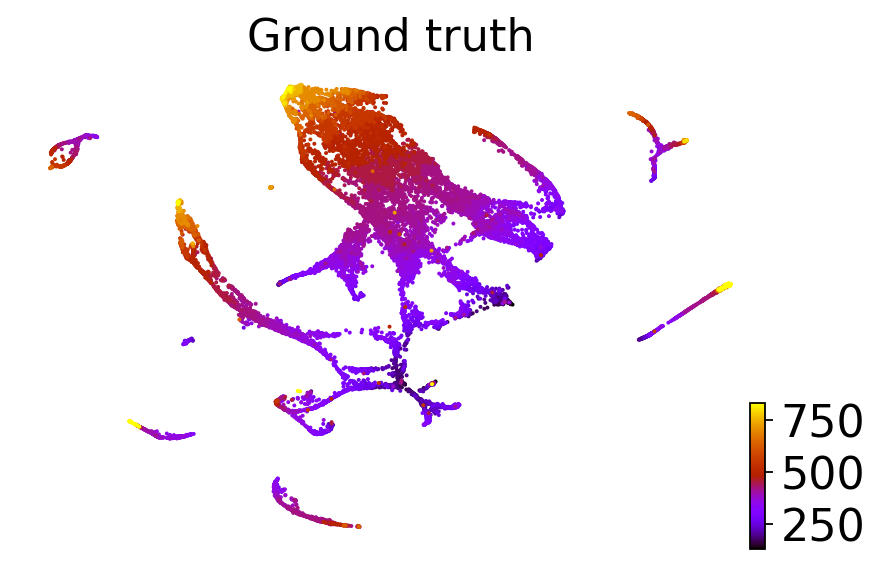

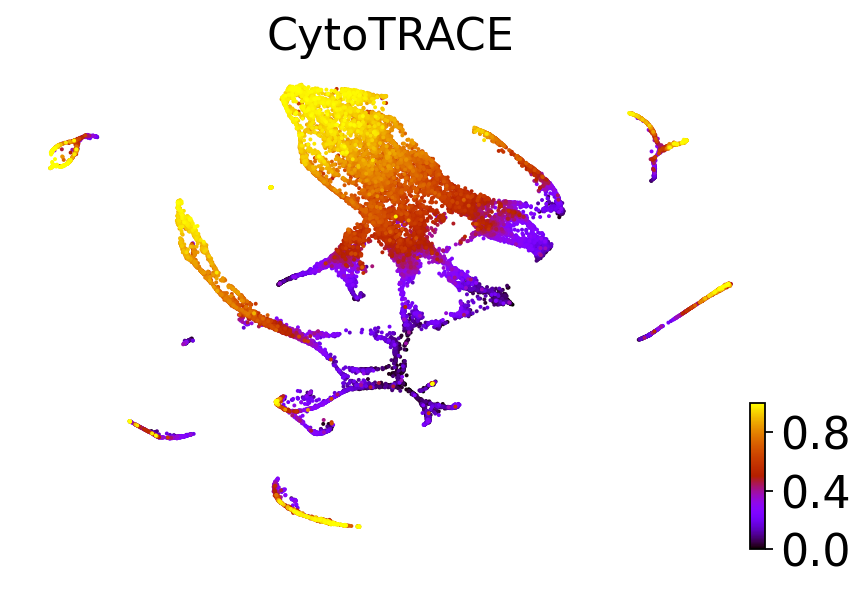

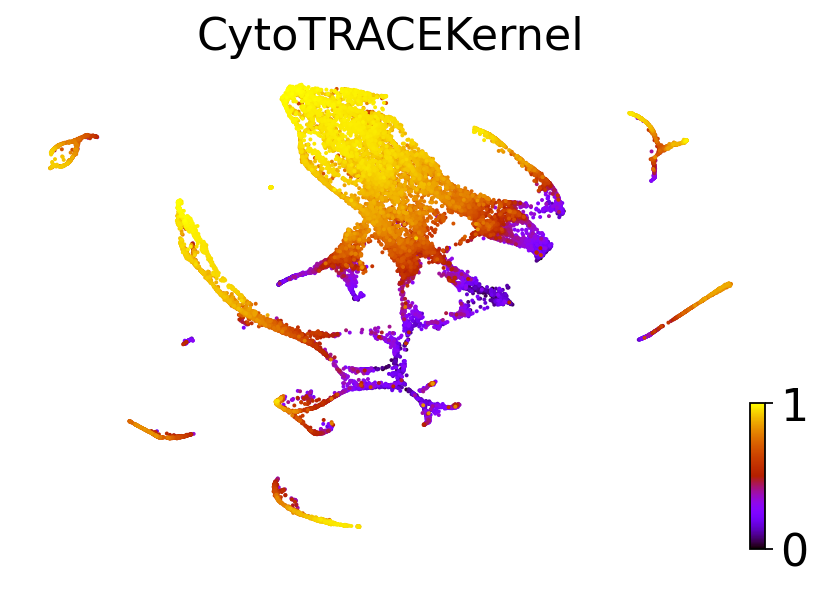

In [14]:
dataset = "C. elegans muscle and mesoderm (Packer et al., Science 2019)"

adatas[dataset].obs["CytroTRACEKernel_ct_pseudotime"] = scores[dataset]

for obs_column in ["Ground truth continuous", "original_ct_pseudotime", "CytroTRACEKernel_ct_pseudotime"]:
    fig, ax = plt.subplots(figsize=(6, 4))
    if obs_column == "Ground truth continuous":
        title = "Ground truth"
    elif obs_column == "original_ct_pseudotime":
        title = "CytoTRACE"
    else:
        title = "CytoTRACEKernel"
    scv.pl.scatter(adatas[dataset], basis="ct", color=obs_column, color_map="gnuplot", title=title, ax=ax)

    if SAVE_FIGURES:
        fig, ax = plt.subplot(figsize=(6, 4))
        scv.pl.scatter(
            adatas[dataset], basis="ct", color=obs_column, color_map="gnuplot", colorbar=False, title="", ax=ax
        )

        if obs_column == "Ground truth continuous":
            suffix = "ground_truth"
        elif obs_column == "original_ct_pseudotime":
            suffix = "cytotrace"
        else:
            suffix = "cytotracekernel"
        fig.savefig(
            FIG_DIR / "cytotrace_kernel" / "benchmark" / f"c_elegans_muscle_mesoderm_{suffix}.pdf",
            format="pdf",
            transparent=True,
            bbox_inches="tight",
        )